# Домашка № 7. Сверточные нейронные сети

In [1]:
!pip install pandas scikit-learn matplotlib

In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from google.colab import drive 
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
quora = pd.read_csv('/gdrive/My Drive/quora/quora.csv')

In [0]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [6]:
quora

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
...,...,...,...
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0


# Мое решение

Сверточные сети относительно хорошо масшабируются на длинные последовательности. Поэтому их часто применяют к отдельным символам, а не токенам. В домашке вам нужно будет обучить большую сверточную модель на символах (отличаться по сути будет только токенизация).

При обучении используйте колбек для отслеживания лучшей модели. Ориентируйтесь на ф1 меру.

Конкретнее задание такое: Обучите модель с минимум 15 слоями, где у каждого слоя разные параметры (Dropout, Conv1d и Pooling считаются слоями, остальное нет). Как мимнимум 4 слоя должны быть наложены друг на друга. Должен быть хотя бы один слой каждого типа.

Советы: Начните с небольших сетей и постепенно добавляйте, не пытайтесь сразу собрать все слои. Сделайте размер эмбединга сильно меньше. Попробуйте паддинг поменьше. Символьная модель может обучаться намного дольше. Иногда кернел может крашиться просто так или из-за слишком больших матриц.

Бонусный балл можно получить за изучение влияния предобработки (нужно ли приводить к нижнему регистру, нужно ли выкидывать не алфавитные символы, помогает ли замена цифр на определенный токен).

In [0]:
def symbols(text):
    symbols = []
    for symbol in text:
        symbols += [symbol]
    return symbols

In [0]:
vocab = Counter()

for text in quora.question_text:
    vocab.update(symbols(text))

In [10]:
len(vocab)

2047

In [0]:
filtered_vocab = set()

for symb in vocab:
    if vocab[symb] > 5:
        filtered_vocab.add(symb)

In [12]:
len(filtered_vocab)

447

In [0]:
symb2id = {'UNK':1, 'PAD':0}

for symb in filtered_vocab:
    symb2id[symb] = len(symb2id)

In [0]:
id2symb = {i:symb for symb, i in symb2id.items()}


In [0]:
X = []

for text in quora.question_text:
    symbs = symbols(text)
    ids = [symb2id.get(symb, 1) for symb in symbs]
    X.append(ids)

In [0]:
MAX_LEN = max(len(x) for x in X)

In [0]:
MEAN_LEN = np.median([len(x) for x in X])


In [18]:
MAX_LEN, MEAN_LEN


(1017, 60.0)

In [0]:
MAX_LEN = 55
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)


In [20]:
X.shape


(1306122, 55)

In [0]:
y = quora.target.values


In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)


### Сверточные слои

In [0]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.weights', 
                                                monitor='val_f1', 
                                                verbose=1, 
                                                save_weights_only=True, 
                                                save_best_only=True,
                                                mode='max', 
                                                save_freq='epoch' 
                                               )

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_f1', 
                                              min_delta=0.01, 
                                              patience=3, 
                                              verbose=1, 
                                              mode='max',
                                              )

In [0]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(symb2id), output_dim=50)(inputs, )
convs = []

conv1 = tf.keras.layers.Conv1D(kernel_size=2, filters=24, strides=1)(embeddings)
conv2 = tf.keras.layers.Conv1D(kernel_size=1, filters=16, strides=1, activation='relu')(conv1)
pool1 = tf.keras.layers.GlobalMaxPooling1D()(conv2)
drop1 = tf.keras.layers.Dropout(0.1)(pool1)
convs.append(drop1)

conv3 = tf.keras.layers.Conv1D(kernel_size=4, filters=32, strides=1)(embeddings)
conv4 = tf.keras.layers.Conv1D(kernel_size=6, filters=16, strides=1, activation='relu')(conv3)
pool2 = tf.keras.layers.GlobalMaxPooling1D()(conv4)
drop2 = tf.keras.layers.Dropout(0.2)(pool2)
convs.append(drop2)

conv5 = tf.keras.layers.Conv1D(kernel_size=8, filters=32, strides=1, kernel_regularizer='l2')(embeddings)
conv6 = tf.keras.layers.Conv1D(kernel_size=10, filters=16, strides=1, activation='relu')(conv5)
pool3 = tf.keras.layers.GlobalAveragePooling1D()(conv6)
drop3 = tf.keras.layers.Dropout(0.3)(pool3)
convs.append(drop3)

conv7 = tf.keras.layers.Conv1D(kernel_size=2, filters=16, strides=2, kernel_regularizer='l2')(embeddings)
conv8 = tf.keras.layers.Conv1D(kernel_size=2, filters=16, strides=2, activation='relu')(conv7)
pool4 = tf.keras.layers.GlobalMaxPooling1D()(conv8)
convs.append(pool4)

concat = tf.keras.layers.concatenate(convs)

dense = tf.keras.layers.Dense(64, activation='relu')(concat)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

In [50]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
          epochs=5)

Epoch 1/5
621/621 [==============================] - 467s 753ms/step - loss: 0.2590 - f1: 0.0192 - val_loss: 0.1825 - val_f1: 0.0801
Epoch 2/5
621/621 [==============================] - 466s 750ms/step - loss: 0.1816 - f1: 0.1373 - val_loss: 0.1713 - val_f1: 0.1824
Epoch 3/5
621/621 [==============================] - 472s 760ms/step - loss: 0.1753 - f1: 0.1967 - val_loss: 0.1693 - val_f1: 0.1407
Epoch 4/5
621/621 [==============================] - 469s 755ms/step - loss: 0.1728 - f1: 0.2093 - val_loss: 0.1665 - val_f1: 0.1719
Epoch 5/5
621/621 [==============================] - 461s 742ms/step - loss: 0.1710 - f1: 0.2241 - val_loss: 0.1655 - val_f1: 0.1828


In [51]:
model.summary()


Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 55)]         0                                            
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, 55, 50)       22450       input_17[0][0]                   
__________________________________________________________________________________________________
conv1d_60 (Conv1D)              (None, 54, 24)       2424        embedding_16[0][0]               
__________________________________________________________________________________________________
conv1d_62 (Conv1D)              (None, 52, 32)       6432        embedding_16[0][0]               
___________________________________________________________________________________________

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


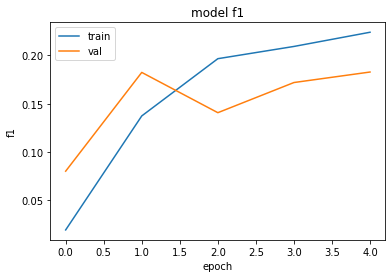

In [52]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()